In [1]:
#@title Authenticate for GDrive and setup paths
import os
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
  from google.colab import auth
  from google.colab import drive
  drive.mount('/content/drive')  
  ROOT_DIR = '/content/drive/My Drive/work/spatial_lda'
  sys.path.insert(1, f"{ROOT_DIR}")
  !pip install lifelines
  !pip install palettable
else:
  ROOT_DIR = '~/spatial_lda'
  
%cd {ROOT_DIR}
PATH_TO_MODELS = f'./models/'
PATH_TO_SPLEEN_DF_PKL = f'./data/spleen/spleen_df.pkl'
PATH_TO_SPLEEN_FEATURES_PKL = f'./data/spleen/spleen_cells_features.pkl'

paths = [
  PATH_TO_MODELS,
  PATH_TO_SPLEEN_DF_PKL
]

paths_exist = {path: os.path.exists(path) for path in paths}
display(paths_exist)
assert all(paths_exist.values())

/Users/zhenghao/spatial_lda


{'./models/': True, './data/spleen/spleen_df.pkl': True}

In [2]:
#@title Import and set processes and set training params
%load_ext autoreload
%autoreload 2

import functools
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import tqdm
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import featurize_spleens
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
import spatial_lda.model

N_PARALLEL_PROCESSES = 8#@param
TRAIN_SIZE_FRACTION = 0.99 #@param
N_TOPICS_LIST = [3, 5, 8, 10] #@param

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Set seaborn visualization parameters

In [3]:
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]
sns.set_context("paper",font_scale=1)
sns.set_style('white')
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

## Load data and featurize

In [4]:
%%time
codex_df_dict = pickle.load(open(PATH_TO_SPLEEN_DF_PKL, "rb"))
for df in codex_df_dict.values():
  df['x'] = df['sample.X']
  df['y'] = df['sample.Y']
wt_samples = [ x for x in codex_df_dict.keys() if x.startswith("BALBc")]
spleen_dfs = dict(zip(wt_samples, [ codex_df_dict[x] for x in wt_samples]))
  
if os.path.exists(PATH_TO_SPLEEN_FEATURES_PKL):
  print('Loading saved features.')
  with open(PATH_TO_SPLEEN_FEATURES_PKL, 'rb') as f:
    spleen_cells_features = pickle.load(f)
else:
  print('Featurizing samples ...')
  
  spleen_cells_features = featurize_spleens(dataset, neighborhood_to_cluster, radius=100,
                                            n_processes=N_PARALLEL_PROCESSES)
  with open(PATH_TO_SPLEEN_FEATURES_PKL, 'wb') as f:
    pickle.dump(spleen_cells_features, f)


Loading saved features.
CPU times: user 295 ms, sys: 318 ms, total: 613 ms
Wall time: 640 ms


## Split training set and compute difference matrices

In [5]:
%%time
spleen_difference_matrices = make_merged_difference_matrices(spleen_cells_features, spleen_dfs,
                                                             'sample.X', 'sample.Y')
all_sample_idxs = spleen_cells_features.index.map(lambda x: x[0])
_sets = train_test_split(spleen_cells_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_sample_idxs)
train_spleen_cells_features, test_spleen_cells__features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_spleen_cells_features, spleen_dfs,
    'sample.X', 'sample.Y')
spleen_idxs = train_spleen_cells_features.index.map(lambda x: x[0])

CPU times: user 7.67 s, sys: 318 ms, total: 7.98 s
Wall time: 3.91 s


## Visualize graphs used to tie neighboring environments

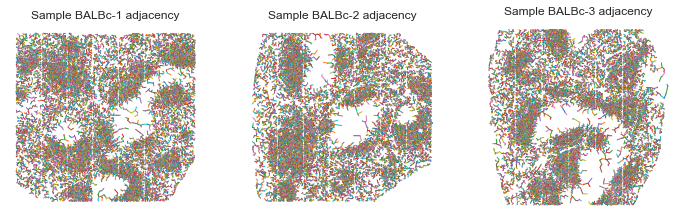

In [6]:
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(spleen_difference_matrices)

plot_samples_in_a_row(spleen_cells_features, _plot_fn, spleen_dfs, tumor_set=['BALBc-1', 'BALBc-2', 'BALBc-3'])

## Inspect spleen cell microenvironment features

In [7]:
spleen_cells_features

,CD4(+) T cells,CD8(+) T cells,CD4(-)CD8(-) cDC,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,F4/80(+) mphs,erythroblasts,plasma cells,CD4(-)CD8(+)cDC,CD106(-)CD16/32(+)Ly6C(+)CD31(-),CD106(+)CD16/32(-)Ly6C(+)CD31(+),...,NK cells,CD106(+)CD16/32(+)CD31(+) stroma,CD4(+)MHCII(+),B220(+) DN T cells,CD3(+) other markers (-),capsule,megakaryocytes,FDCs,CD31(hi) vascular,CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma
"(BALBc-1, 7)",16.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 10)",5.0,2.0,0.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 14)",1.0,4.0,0.0,0.0,8.0,5.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 16)",21.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 20)",6.0,0.0,0.0,3.0,8.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(BALBc-3, 101766)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
"(BALBc-3, 101771)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(BALBc-3, 101774)",2.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-3, 101776)",15.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Spatial LDA results



## Parameter sweep

In [8]:
from spatial_lda.model import order_topics_consistently
spatial_lda_models = {}  
difference_penalty = 0.25  
for n_topics in N_TOPICS_LIST:
  path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/spleen_training',
                                  f'penalty={difference_penalty}',
                                  f'topics={n_topics}',
                                  f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'
  if not os.path.exists(path_to_train_model):
    print(f'Running n_topics={n_topics}, d={difference_penalty}\n')
    spatial_lda_model = spatial_lda.model.train(sample_features=train_spleen_cells_features, 
                                                difference_matrices=train_difference_matrices,
                                                difference_penalty=difference_penalty,
                                                n_topics=n_topics,
                                                n_parallel_processes=N_PARALLEL_PROCESSES,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5)
    spatial_lda_models[n_topics] = spatial_lda_model
    with open(path_to_train_model, 'wb') as f:
      pickle.dump(spatial_lda_model, f)    
  else:
    with open(path_to_train_model, 'rb') as f:
      spatial_lda_models[n_topics] = pickle.load(f)
      
order_topics_consistently(spatial_lda_models.values())     

## Load models with different number of topics and the same difference penalty

In [9]:
lda_3 = spatial_lda_models[3]
topic_weights_3 = lda_3.topic_weights
lda_5 = spatial_lda_models[5]
topic_weights_5 = lda_5.topic_weights
lda_8 = spatial_lda_models[8]
topic_weights_8 = lda_8.topic_weights
lda_10 = spatial_lda_models[10]
topic_weights_10 = lda_10.topic_weights
samples = ['BALBc-1', 'BALBc-2', 'BALBc-3']

### Visualizing topics on regular cells

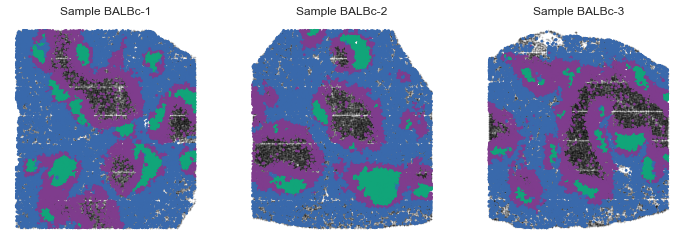

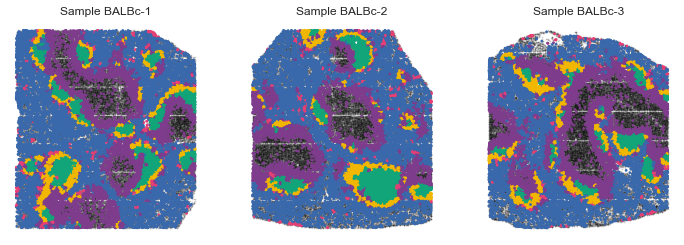

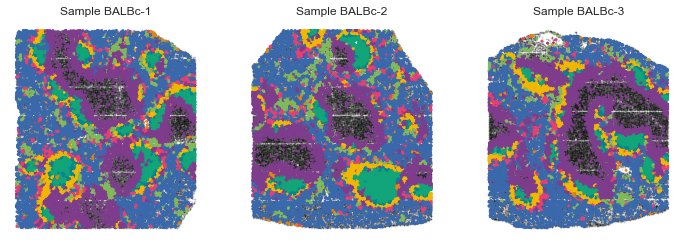

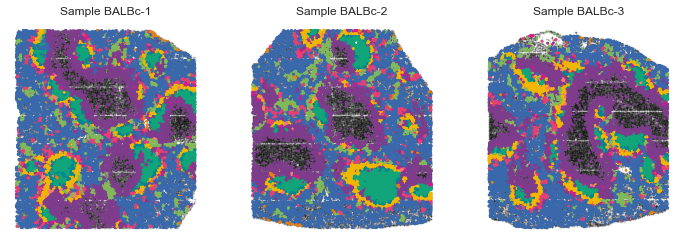

In [10]:
from spatial_lda.visualization import plot_samples_in_a_row
plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor, spleen_dfs, tumor_set=samples)
plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor, spleen_dfs, tumor_set=samples)
plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor, spleen_dfs, tumor_set=samples)
plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor, spleen_dfs, tumor_set=samples)

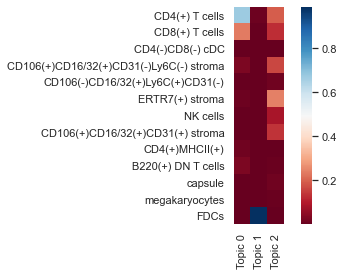

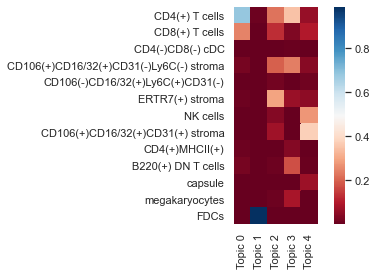

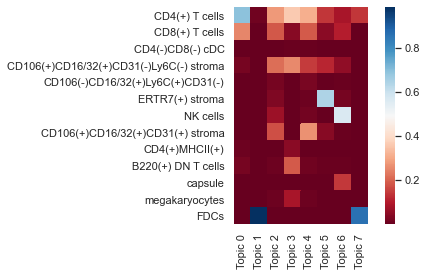

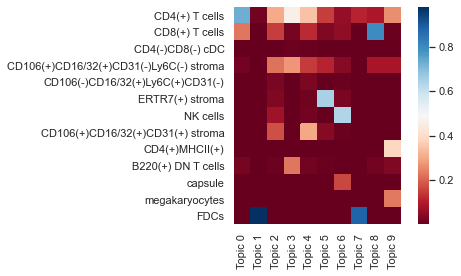

In [11]:
from spatial_lda.visualization import plot_topics_heatmap
idcs_take = [0,1,2,3,8,13,14,15,16,17,19,20,21]
normalizer = lambda ar: (ar/np.sum(ar, axis=1, keepdims=True)).T
plt.figure()
plot_topics_heatmap(lda_3.components_[:, idcs_take], spleen_cells_features.columns[idcs_take], normalizer)
plt.figure()
plot_topics_heatmap(lda_5.components_[:, idcs_take], spleen_cells_features.columns[idcs_take], normalizer)
plt.figure()
plot_topics_heatmap(lda_8.components_[:, idcs_take], spleen_cells_features.columns[idcs_take], normalizer)
plt.figure()
plot_topics_heatmap(lda_10.components_[:, idcs_take], spleen_cells_features.columns[idcs_take], normalizer)